# Ginkgo grid - generalised

In [30]:

import pyprob
import numpy as np
import ot
import torch
import cProfile
import pickle

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from torch.utils.data import DataLoader
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


import sklearn as skl
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from joblib import Parallel, delayed

from geomloss import SamplesLoss
sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
def sinkhorn_t(x,y):
    x = torch.as_tensor(x)
    y = torch.as_tensor(y)
    return sinkhorn(x,y)

def ot_dist(x,y):
    x = x.detach().numpy()
    y = y.detach().numpy()
    a = ot.unif(len(x))
    b = ot.unif(len(y))
    Mat = ot.dist(x, y, metric='euclidean')
    distance = torch.tensor(ot.emd2(a,b,Mat))
    return distance



## Prepare functions

In [31]:
QCD_mass = to_tensor(30.)
#rate=to_tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = to_tensor([1.,1.,1.])
jetP = to_tensor(400.)
jetvec = jetP * jetdir / torch.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = to_tensor(0.3**2)
M2start = to_tensor(QCD_mass**2)
jetM = torch.sqrt(M2start) ## Mass of initial jet
jet4vec = torch.cat((torch.sqrt(jetP**2 + jetM**2).reshape(-1), jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100


ginkgo_simulator = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)

prior_min = [1e-3,1e-3]
prior_max = [30.,30.]
prior_full = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

In [3]:
def theta_grid(num_x, num_y):
    
    x_coords = torch.linspace(prior_min[0], prior_max[0], num_x+2)[1:-1]
    y_coords = torch.linspace(prior_min[1], prior_max[1], num_y+2)[1:-1]

    return torch.cartesian_prod(x_coords, y_coords)

In [4]:
def multi_ot_score(input, points_to_compare):
    """ This computes the optimal transport score of the input relative to the data points in 'points_to_compare'.

    Args:
        input: A tensor containing the leaves produced by ginkgo simulator.
        points_to_compare: A list of tensors containing leaves produced by ginkgo.

    Returns:
        Optimal tranpsort distances from the input to each point in points_to_compare 
    """
    distances = []
    for leaves in points_to_compare:
        distances.append(ot_dist(input,leaves))
    return torch.tensor(distances)

def get_ot_simulator(points_to_compare):
    """ Wrapper to generate simulator which takes parameters and calculates distances with the presimulated data in points_to_compare.

    Args:
        points_to_compare: points to calculate distances to.

    Returns:
        function: Returns function which runs the forward simulation and calculates summaries given a set of parameters.
    """
    def ot_simulator(params):
        input = ginkgo_simulator(params)['leaves']
        return multi_ot_score(input, points_to_compare)
        
    return ot_simulator

def create_points_from_thetas(thetas):
    data = []
    for theta in thetas:
        data.append(ginkgo_simulator(theta)['leaves'])
    return data

In [23]:
ref33=ginkgo_simulator([3,3])['leaves']
ref59 =ginkgo_simulator([5,9])['leaves']
ref1010 = ginkgo_simulator([10,10])['leaves']
ref153 = ginkgo_simulator([15,3])['leaves']

## Examples

In [44]:
thetas = theta_grid(8,8)
data = create_points_from_thetas(thetas)
simple_simulator = get_ot_simulator(data)

In [46]:
posterior=infer(simple_simulator, prior_full, method='SNPE', 
                  num_simulations=5000, num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.



[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 47 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

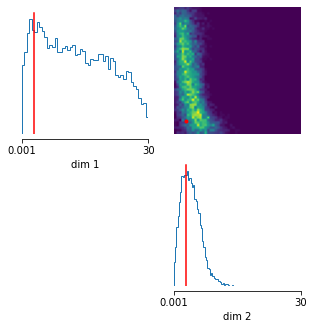

In [53]:
samples = posterior.sample((10000,),x=multi_ot_score(ref33,data))
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

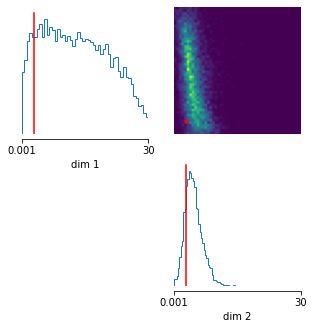

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

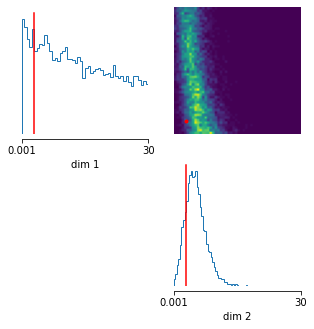

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

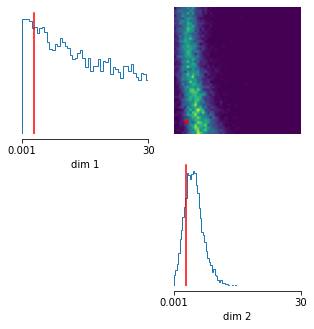

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

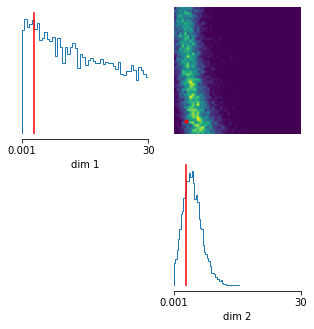

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

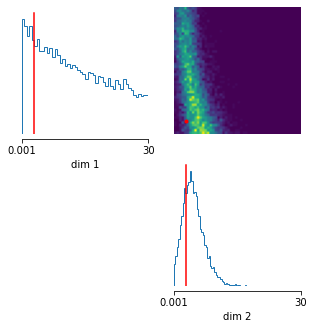

In [55]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(simple_simulator, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(multi_ot_score(ref33,data))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.], [1e-3,30.]],
                            ticks=[[1e-3,30.], [1e-3,30.]],
                            figsize=(5,5),
                            points=np.array([3,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 67 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

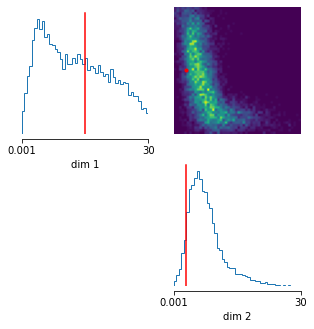

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

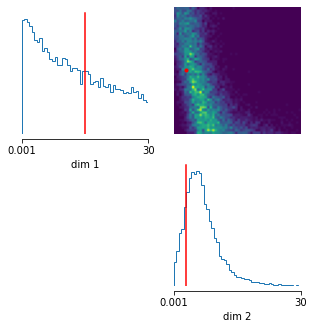

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

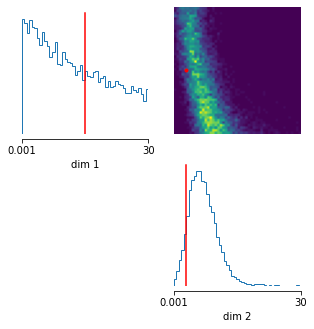

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

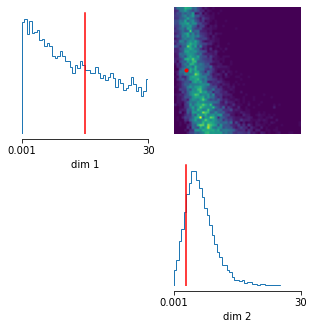

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

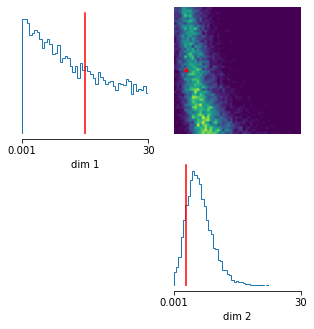

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

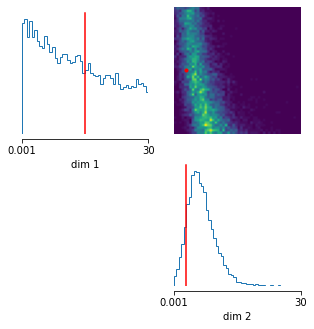

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

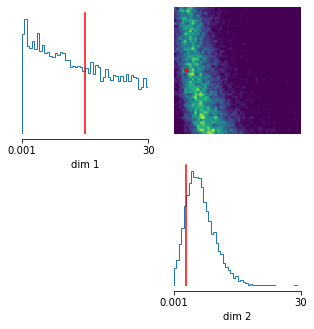

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

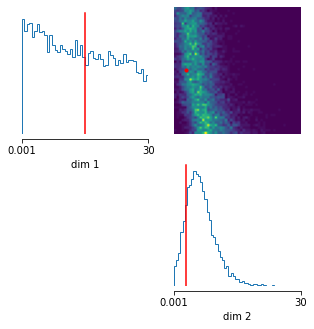

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

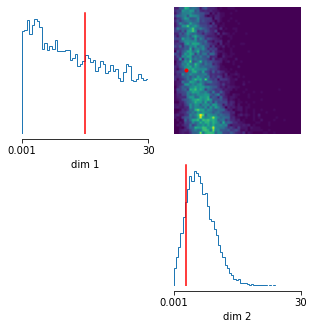

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

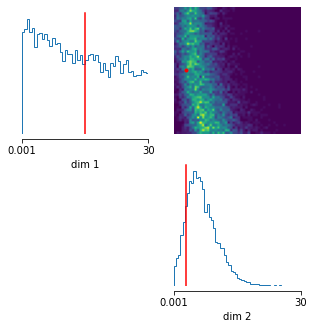

In [57]:
num_rounds = 10
posteriors = []
simulator, prior = prepare_for_sbi(simple_simulator, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(multi_ot_score(ref153,data))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.], [1e-3,30.]],
                            ticks=[[1e-3,30.], [1e-3,30.]],
                            figsize=(5,5),
                            points=np.array([15,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

## Include Kernel

In [77]:
theta_true = torch.tensor([15,3])
obs = ginkgo_simulator(theta_true)['leaves']
data_plus = [obs]+data
obs_distances = multi_ot_score(obs,data_plus)

In [80]:
full_simulator = get_ot_simulator(data_plus)

In [76]:
def kernel(xs): # Doesn't work
    
    distances = xs[:,0]
    var = torch.var(distances)

    def wrapped(x):
        return torch.exp(-0.5*x[:,0]**2/(var))
    
    return wrapped

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 48 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

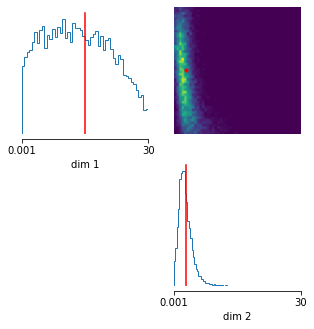

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

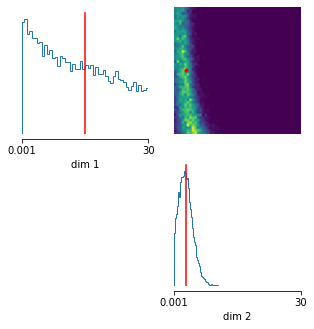

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

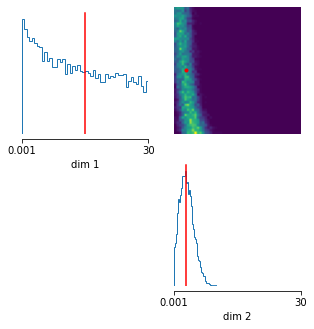

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

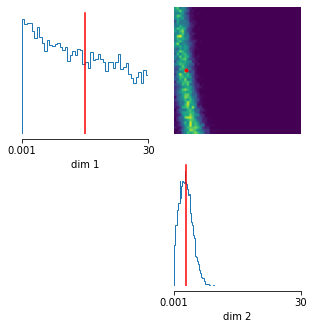

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

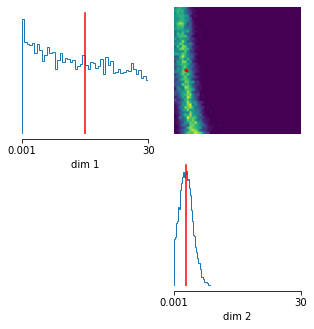

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

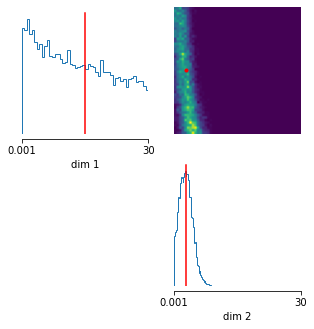

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

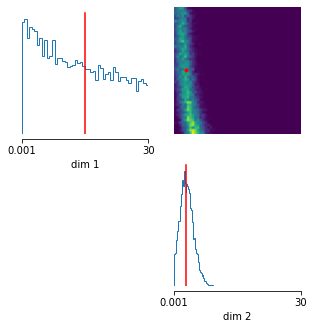

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

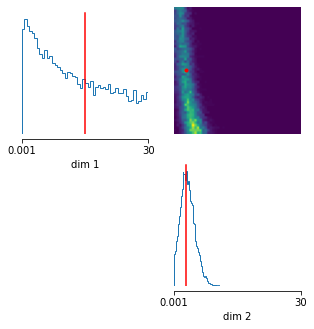

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

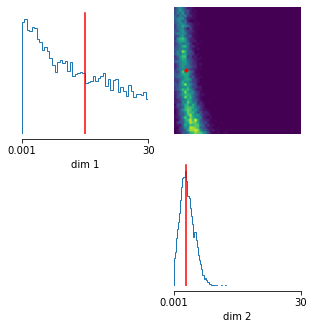

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

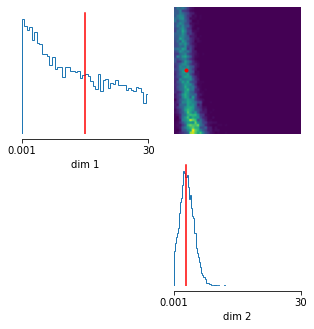

In [81]:
num_rounds = 10
posteriors = []
simulator, prior = prepare_for_sbi(full_simulator, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(calibration_kernel=kernel(inference.get_simulations()[1]))
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(obs_distances)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.], [1e-3,30.]],
                            ticks=[[1e-3,30.], [1e-3,30.]],
                            figsize=(5,5),
                            points=np.array([15,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

## Can we deduce root?

In [9]:
prior_single = utils.torchutils.BoxUniform(low=torch.tensor([1e-3]),high=torch.tensor([10.]))

def theta_linspace(num_x, y): # We can still use grid though...
    
    x_coords = torch.linspace(prior_min[0], prior_max[0], num_x+2)[1:-1]
    y_coords = torch.tensor([float(y)])

    return torch.cartesian_prod(x_coords, y_coords)

In [15]:
def get_ot_simulator_single(points_to_compare, y_val):
    """ Wrapper to generate simulator which takes parameters and calculates distances with the presimulated data in points_to_compare.

    Args:
        points_to_compare: points to calculate distances to.

    Returns:
        function: Returns function which runs the forward simulation and calculates summaries given a set of parameters.
    """
    def ot_simulator(param):
        theta = [torch.as_tensor(param),torch.as_tensor(y_val)]
        input = ginkgo_simulator(theta)['leaves']
        return multi_ot_score(input, points_to_compare)
        
    return ot_simulator

In [16]:
simple_simulator = get_ot_simulator_single(data,3)
posterior=infer(simple_simulator, prior_single, method='SNPE', 
                  num_simulations=5000, num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/sragy/sb_inference/sbi/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 39 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

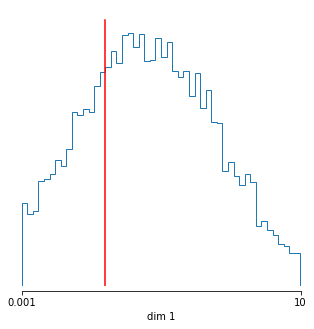

In [17]:
reference_obs=simple_simulator(3)
samples = posterior.sample((10000,),x=reference_obs)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,10.]],
                        ticks=[[1e-3,10.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbi/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 41 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

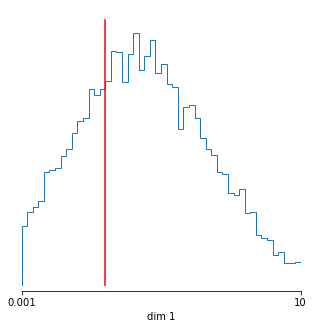

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

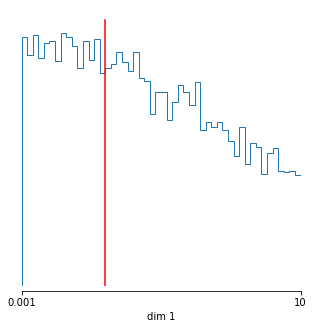

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

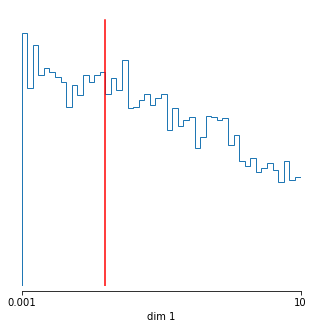

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

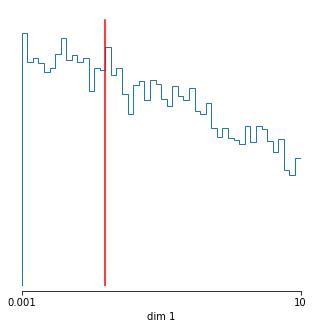

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

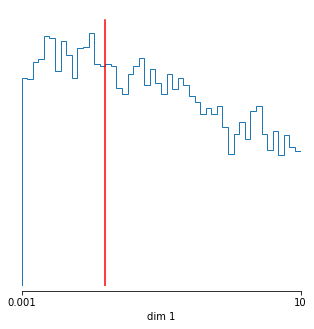

In [18]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(simple_simulator, prior_single)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(reference_obs)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,10.]],
                            ticks=[[1e-3,10.]],
                            figsize=(5,5),
                            points=np.array([3,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

### Single distances

In [156]:
def get_ot_simulator_single(rate, ref):
    def ot_simulator(param):
        internal_rate = torch.as_tensor(rate)
        theta = torch.tensor([param,internal_rate])
        output = ginkgo_simulator(theta)['leaves']
        return torch.tensor([ot_dist(ref, output)])
    return ot_simulator

In [ ]:
ref_ot_single = 

### Leaf summaries

In [84]:
# Leaf counting.
leaf_ct_3 = torch.tensor([len(ginkgo_simulator([3,3])['leaves']) for _ in range(2000)])
leaf_ct_8 = torch.tensor([len(ginkgo_simulator([8,3])['leaves']) for _ in range(2000)])


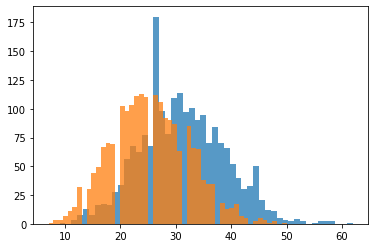

In [85]:
plt.hist(leaf_ct_3.detach().numpy(), bins = 50, alpha = 0.75)
plt.hist(leaf_ct_8.detach().numpy(), bins=50, alpha = 0.75)
plt.show()

In [82]:
# ot_dist.
ref_data = ginkgo_simulator([3,3])['leaves']
ot_ct_3 = torch.tensor([ot_dist(ginkgo_simulator([3,3])['leaves'], ref_data) for _ in range(2000)])
ot_ct_8 = torch.tensor([ot_dist(ginkgo_simulator([8,3])['leaves'], ref_data) for _ in range(2000)])


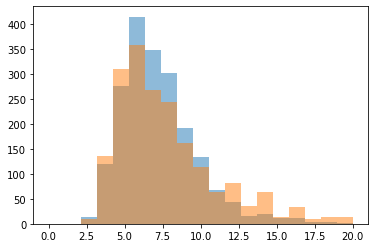

In [79]:
plt.hist(ot_ct_3.detach().numpy(), bins=np.linspace(0,20,20), alpha=0.5)
plt.hist(ot_ct_8.detach().numpy(), bins=np.linspace(0,20,20), alpha=0.5)
plt.show()

In [89]:
ot_ct_8.numpy().mean()


8.911263

In [102]:
def get_leaf_ct_simulator_single(rate):
    def leaf_ct_simulator(param):
        internal_rate = torch.as_tensor(rate)
        theta = torch.tensor([param,internal_rate])
        return torch.tensor([len(ginkgo_simulator(theta)['leaves'])])
    return leaf_ct_simulator

In [103]:
leaf_root_rate_simulator = get_leaf_ct_simulator_single(3)
ref_lrrs = leaf_root_rate_simulator(3)

In [104]:
posterior=infer(leaf_root_rate_simulator, prior_single, method='SNPE', 
                  num_simulations=5000, num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.








/home/sragy/sb_inference/sbi/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 39 epochs.

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbi/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 39 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

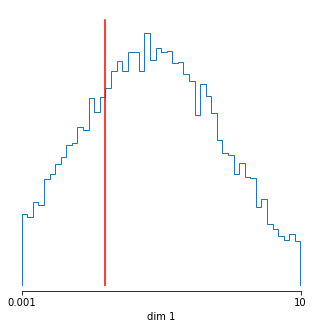

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 65 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

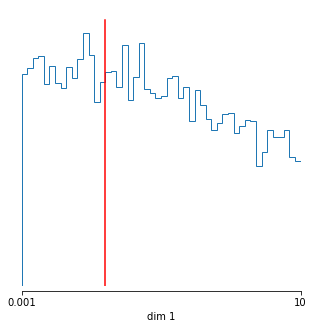

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

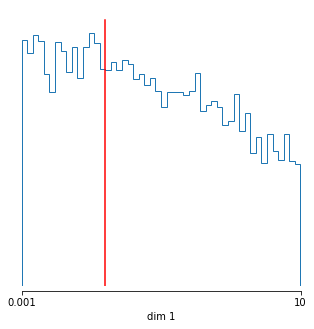

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

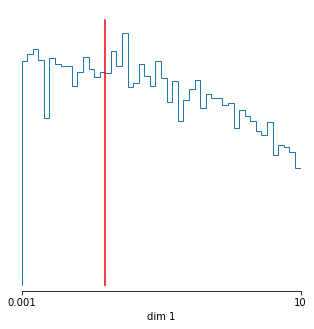

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

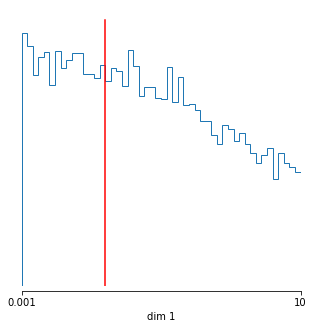

In [109]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(leaf_root_rate_simulator, prior_single)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(ref_lrrs)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,10.]],
                            ticks=[[1e-3,10.]],
                            figsize=(5,5),
                            points=np.array([3,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

In [126]:
# Sanity check likelihood ratios

def count_region(array, x_min, x_max):
    return ((array > x_min) & (array < x_max)).sum()
    

In [128]:
count_region(samples,2.9,3.1)/count_region(samples,7.9,8.1)

tensor(1.3827)

In [152]:
def counter(target, num_runs, theta_min, theta_max):
    count = 0
    for i in range(num_runs):
        randomizer = torch.rand(1)*(theta_max - theta_min)
        theta = theta_min + randomizer
        if len(ginkgo_simulator([theta,3])['leaves']) == target:
            count+=1
    return count

In [153]:
count_3=counter(ref_lrrs, 5000, 2.9,3.1)
count_8=counter(ref_lrrs, 5000, 7.9,8.1)

In [155]:
count_3/count_8

1.5166666666666666

## New summaries

In [26]:
def summaries(leaves):
    leaf_count = torch.as_tensor(len(leaves))
    energy_variance = torch.as_tensor(leaves[:,0].var())
    return torch.tensor([leaf_count, energy_variance])

def simulate_summaries(params):
    leaves = ginkgo_simulator(params)['leaves']
    return summaries(leaves)


def summaries_wdist(leaves, reference_obs):

    leaf_count = torch.as_tensor(len(leaves))
    energy_variance = torch.as_tensor(leaves[:,0].var())
    if leaves.isnan().any():
        distance = torch.as_tensor(np.inf)
    else:
        distance = torch.as_tensor(sinkhorn_t(leaves, reference_obs))
  

    all_summs = torch.tensor([leaf_count, energy_variance, distance])

    return all_summs

def all_sums_wrapper(data):
    """
    Produces a wrapper for a function returning summaries.
    """
    def parameter_wrapper(params):
        leaves = simulator(params)['leaves']
        return summaries(leaves, data)

    return parameter_wrapper

In [32]:
posterior=infer(simulate_summaries, prior_full, method='SNPE', 
                  num_simulations=5000, num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 171 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

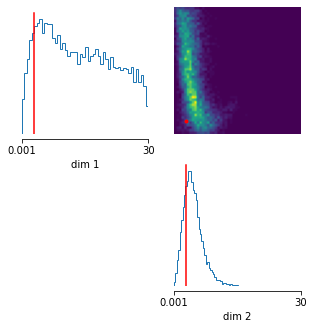

In [34]:
samples = posterior.sample((10000,),x=summaries(ref33))
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

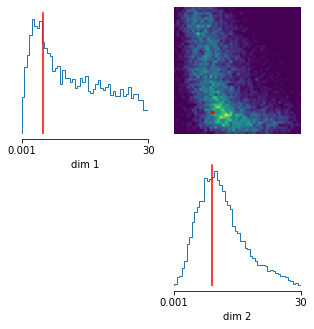

In [35]:
samples = posterior.sample((10000,),x=summaries(ref59))
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([5,9]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

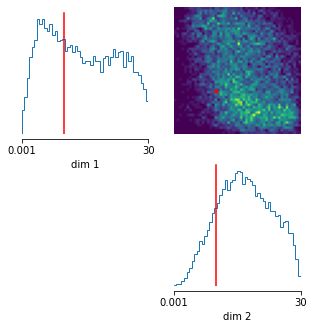

In [36]:
samples = posterior.sample((10000,),x=summaries(ref1010))
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([10,10]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 62 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

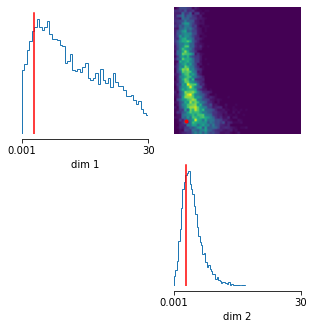

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

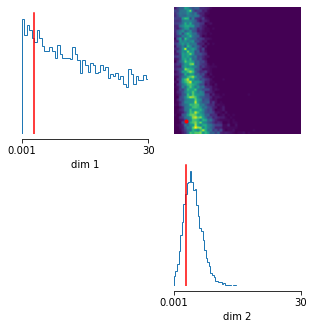

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

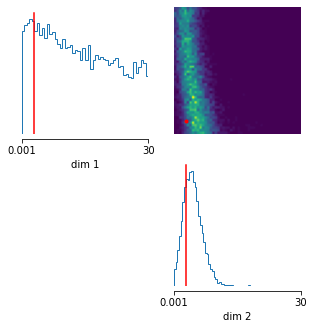

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

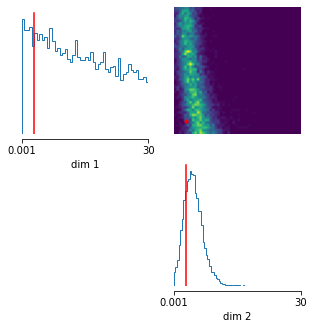

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

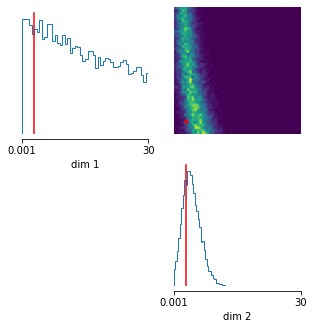

In [38]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(simulate_summaries, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(summaries(ref33))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.]],
                            ticks=[[1e-3,30.]],
                            figsize=(5,5),
                            points=np.array([3,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 132 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

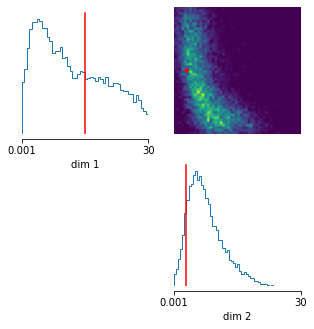

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

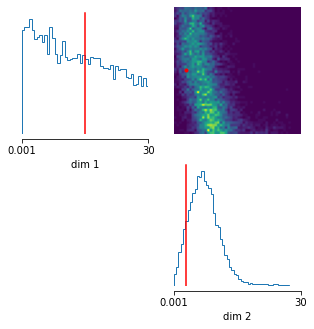

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

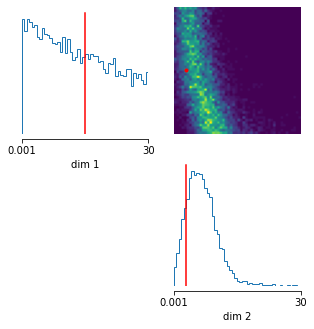

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

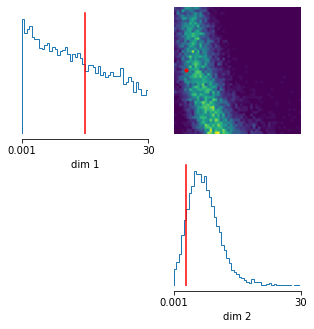

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

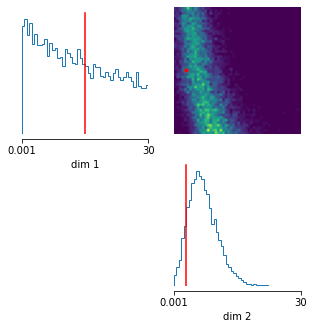

In [40]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(simulate_summaries, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(summaries(ref153))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.]],
                            ticks=[[1e-3,30.]],
                            figsize=(5,5),
                            points=np.array([15,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()